# Clustering initialization

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
# This will automatically reload modules before executing code that depends on them.

from copy import deepcopy

# 3rd party imports
import numpy as np
np.set_printoptions(linewidth=1000)
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from pprint import pprint

# local imports
from modules import jacobian
from modules.data import Data
from cluster_modules import cluster, data_utils, reg_utils

## Create sample datasets

Plotted 30 point correspondences
Set 1 - X range: [50.0, 150.0], Y range: [50.3, 149.7]
Set 2 - X range: [82.8, 217.2], Y range: [51.8, 148.2]
Correspondence distances - Mean: 58.73, Std: 14.59, Max: 83.64


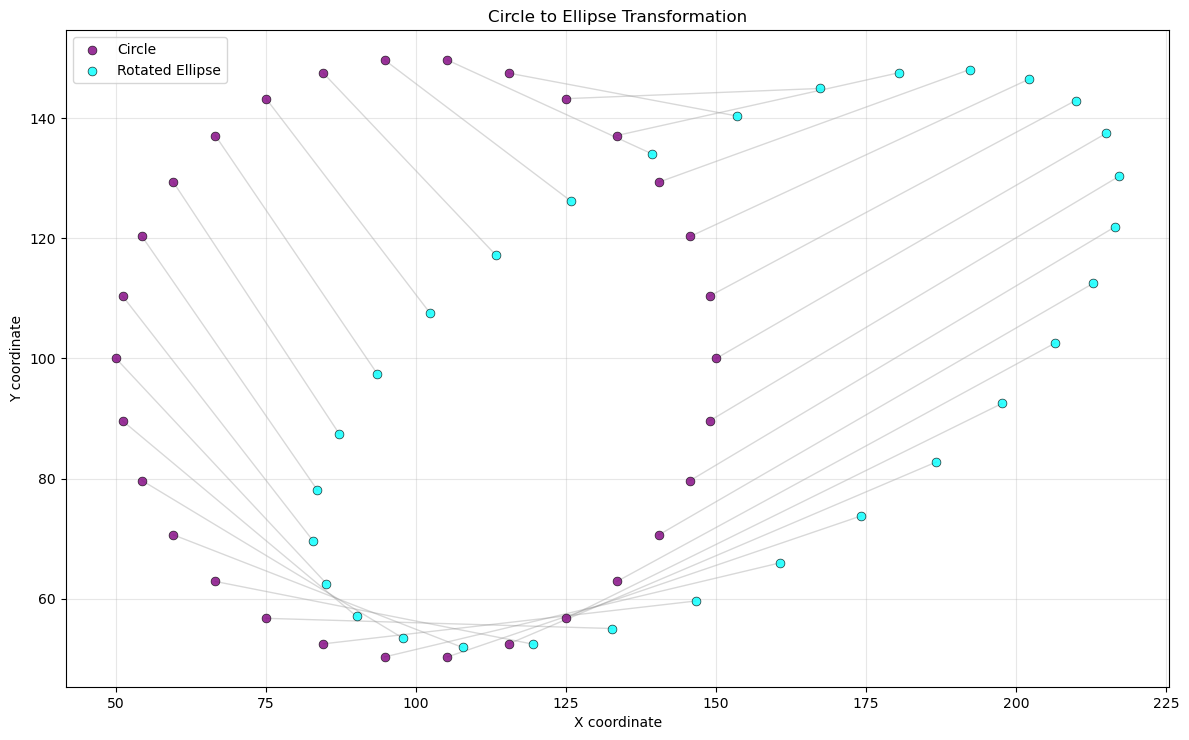

In [2]:
circle_points, ellipse_points = data_utils.circle_to_ellipse_correspondences()

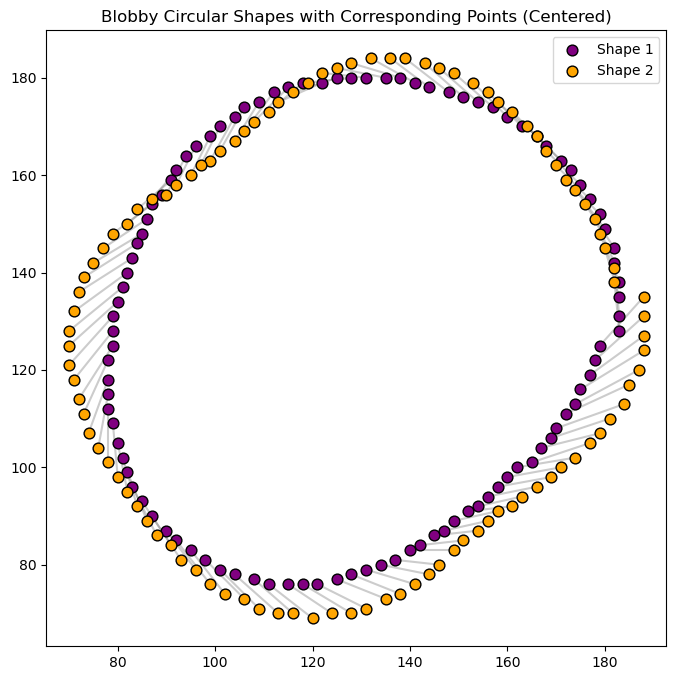

In [3]:
blob1, blob2 = data_utils.create_blobby_circular_shapes(n_points=100, plot=True, noise_scale=6)

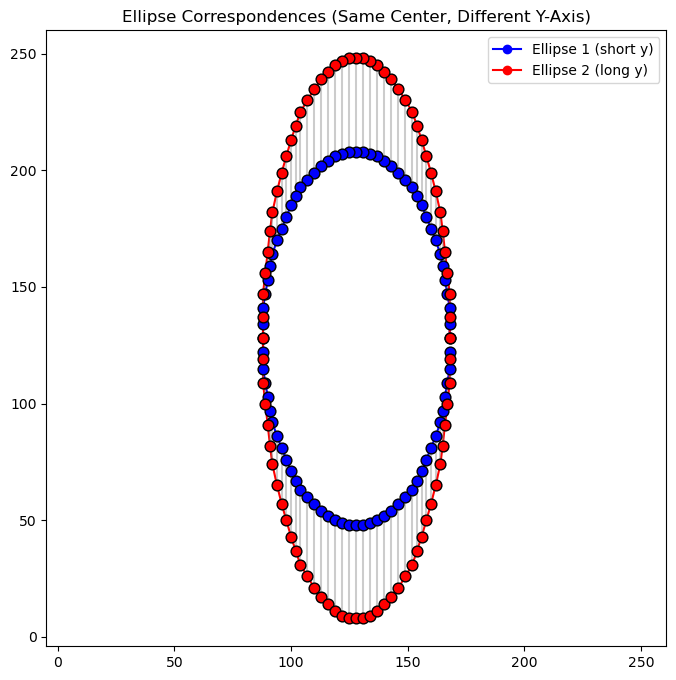

In [4]:
ellipse1, ellipse2 = data_utils.create_ellipse_correspondences(n_points=80, plot=True)

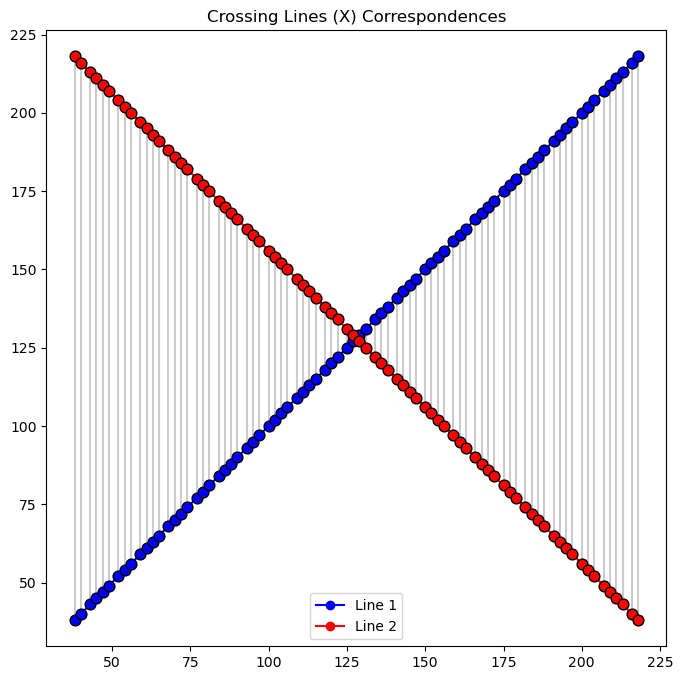

In [5]:
line1, line2 = data_utils.create_crossing_lines_correspondences(n_points=80, plot=True)

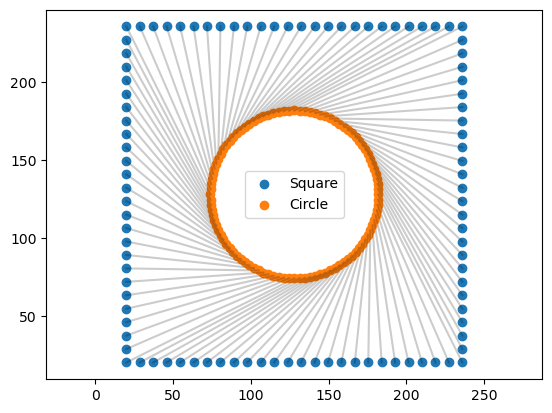

In [6]:
def square_to_circle_correspondences(n_points=100, square_size=1.0, circle_radius=1.0, resolution=(256, 256), padding=20):
    """
    Generates n_points correspondences from a square to a circle,
    mapped to a given image resolution with padding from the edges.
    Returns:
        square_points: (n_points, 2) array of (x, y) in image coordinates
        circle_points: (n_points, 2) array of (x, y) in image coordinates
    """
    # Square points: uniformly sample points along the square perimeter in CCW order starting from bottom left
    per_side = n_points // 4
    remainder = n_points % 4
    sides = [per_side] * 4
    for i in range(remainder):
        sides[i] += 1

    # Bottom (left to right)
    x0 = np.linspace(-square_size, square_size, sides[0], endpoint=False)
    y0 = np.full_like(x0, -square_size)
    # Right (bottom to top)
    y1 = np.linspace(-square_size, square_size, sides[1], endpoint=False)
    x1 = np.full_like(y1, square_size)
    # Top (right to left)
    x2 = np.linspace(square_size, -square_size, sides[2], endpoint=False)
    y2 = np.full_like(x2, square_size)
    # Left (top to bottom)
    y3 = np.linspace(square_size, -square_size, sides[3], endpoint=False)
    x3 = np.full_like(y3, -square_size)

    square_points = np.concatenate([
        np.stack([x0, y0], axis=1),
        np.stack([x1, y1], axis=1),
        np.stack([x2, y2], axis=1),
        np.stack([x3, y3], axis=1)
    ], axis=0)

    # Map each square point to a circle point by angle, starting at -pi/2 (bottom)
    angles = np.linspace(-np.pi/2, 3*np.pi/2, n_points, endpoint=False)
    circle_points = np.stack([
        circle_radius * np.cos(angles),
        circle_radius * np.sin(angles)
    ], axis=1)

    # Center both shapes in the image
    img_center = np.array(resolution) / 2

    def to_image_coords(points, obj_size):
        # Scale so that the largest shape fits within the padded area
        scale = (np.array(resolution) - 2 * padding) / (2 * max(square_size, circle_radius))
        img_points = points * scale + img_center
        return img_points

    square_img_points = to_image_coords(square_points, square_size)
    circle_img_points = to_image_coords(circle_points, circle_radius)

    return square_img_points, circle_img_points

# Usage example
square_pts, circle_pts = square_to_circle_correspondences(n_points=100, circle_radius=0.5)
plt.scatter(square_pts[:,0], square_pts[:,1], label='Square')
plt.scatter(circle_pts[:,0], circle_pts[:,1], label='Circle')
for i in range(len(square_pts)):
    plt.plot([square_pts[i,0], circle_pts[i,0]], [square_pts[i,1], circle_pts[i,1]], 'k-', alpha=0.2)
plt.legend()
plt.axis('equal')
plt.show()

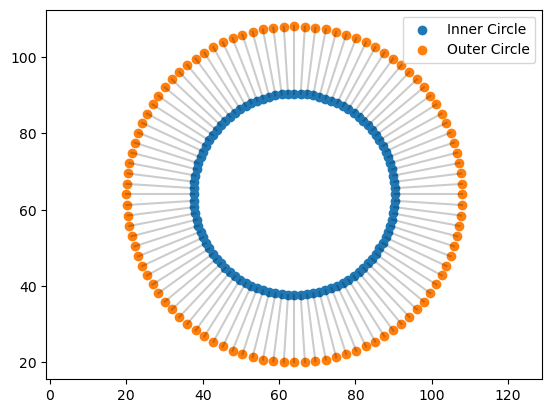

In [7]:
def circle_to_circle_correspondences(n_points=100, inner_radius=0.5, outer_radius=1.0, resolution=(256, 256), padding=20):
    """
    Generates n_points correspondences from an inner circle to an outer circle,
    mapped to a given image resolution with padding from the edges.
    Returns:
        inner_points: (n_points, 2) array of (x, y) in image coordinates
        outer_points: (n_points, 2) array of (x, y) in image coordinates
    """
    # Sample points along the perimeter, CCW starting from bottom
    angles = np.linspace(-np.pi/2, 3*np.pi/2, n_points, endpoint=False)
    inner_points = np.stack([
        inner_radius * np.cos(angles),
        inner_radius * np.sin(angles)
    ], axis=1)
    outer_points = np.stack([
        outer_radius * np.cos(angles),
        outer_radius * np.sin(angles)
    ], axis=1)

    # Center both shapes in the image
    img_center = np.array(resolution) / 2

    def to_image_coords(points, obj_size):
        # Scale so that the largest shape fits within the padded area
        scale = (np.array(resolution) - 2 * padding) / (2 * outer_radius)
        img_points = points * scale + img_center
        return img_points

    inner_img_points = to_image_coords(inner_points, inner_radius)
    outer_img_points = to_image_coords(outer_points, outer_radius)

    return inner_img_points, outer_img_points

# Usage example
inner_pts, outer_pts = circle_to_circle_correspondences(n_points=100, resolution=(128, 128), inner_radius=0.15, outer_radius=0.25)
plt.scatter(inner_pts[:,0], inner_pts[:,1], label='Inner Circle')
plt.scatter(outer_pts[:,0], outer_pts[:,1], label='Outer Circle')
for i in range(len(inner_pts)):
    plt.plot([inner_pts[i,0], outer_pts[i,0]], [inner_pts[i,1], outer_pts[i,1]], 'k-', alpha=0.2)
plt.legend()
plt.axis('equal')
plt.show()

# Correspondence density comparison

## Full double-helix

In [8]:
RUN_EXPERIMENT = False

if RUN_EXPERIMENT:
    # Create a specific double helix for correspondence analysis
    print("\n=== Creating Double Helix for Point Correspondence ===")

    resolution = (256, 256)  # Example resolution for the data
    points_to_skip = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Skip every nth point for better visualization

    #####################################################################################################

    for num_points_skip in points_to_skip:
        print(f"\n=== Resolution / {num_points_skip} ===")

        helix_wave1, helix_wave2, _ = data_utils.create_double_helix_waves(
            grid_size=256,
            num_cycles=2,
            amplitude_ratio=0.03,
            phase_offset=np.pi,  # 180 degrees for maximum separation
            padding_ratio=0.1,
            plot=False,
            horizontal=False  # Set horizontal to False for vertical helix
        )

        # Decrease point density for better visualization
        helix_wave1 = helix_wave1[::num_points_skip]  # Take every second point
        helix_wave2 = helix_wave2[::num_points_skip]  # Take every second point

        # Plot the correspondences between the two helical waves
        data_utils.plot_point_correspondences(helix_wave1, helix_wave2,
                                labels=('Moving points', 'Fixed points'),
                                colors=('red', 'blue'),
                                title=f'Double Helix Point Correspondences (resolution / {num_points_skip})',
                                show_indices=False,
                                line_alpha=0.2,  # More transparent lines to show the pattern better
                                point_size=20)

        # Swap columns to match expected format (x, y)
        helix_wave1 = helix_wave1[:, [1, 0]]  # Swap to (y, x) format
        helix_wave2 = helix_wave2[:, [1, 0]]  # Swap to (y, x) format 

        # Add 0s on the first axis to format for Data class
        helix_wave1 = np.pad(helix_wave1, ((0, 0), (1, 0)), mode='constant', constant_values=0)
        helix_wave2 = np.pad(helix_wave2, ((0, 0), (1, 0)), mode='constant', constant_values=0)

        # Run Laplacian
        d = Data(helix_wave1, helix_wave2, resolution)
        d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
            title=f"Double helix (point resolution / {num_points_skip})\nMin Jdet: {d.min():.2f}, Negatives: {d.count_negatives()}")

## Downwards cluster

In [9]:
if RUN_EXPERIMENT:
    # Create a specific double helix for correspondence analysis
    print("\n=== Creating Double Helix for Point Correspondence ===")

    resolution = (256, 256)  # Example resolution for the data
    points_to_skip = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Skip every nth point for better visualization

    #####################################################################################################

    for num_points_skip in points_to_skip:
        print(f"\n=== Resolution / {num_points_skip} ===")

        helix_wave1, helix_wave2, _ = data_utils.create_double_helix_waves(
            grid_size=256,
            num_cycles=2,
            amplitude_ratio=0.03,
            phase_offset=np.pi,  # 180 degrees for maximum separation
            padding_ratio=0.1,
            plot=False,
            horizontal=False  # Set horizontal to False for vertical helix
        )

        # Decrease point density for better visualization
        helix_wave1 = helix_wave1[::num_points_skip]  # Take every second point
        helix_wave2 = helix_wave2[::num_points_skip]  # Take every second point

        # Plot the correspondences between the two helical waves
        data_utils.plot_point_correspondences(helix_wave1, helix_wave2,
                                labels=('Moving points', 'Fixed points'),
                                colors=('red', 'blue'),
                                title='Double Helix Point Correspondences',
                                show_indices=False,
                                line_alpha=0.2,  # More transparent lines to show the pattern better
                                point_size=20)

        # Swap columns to match expected format (x, y)
        helix_wave1 = helix_wave1[:, [1, 0]]  # Swap to (y, x) format
        helix_wave2 = helix_wave2[:, [1, 0]]  # Swap to (y, x) format 

        # Add 0s on the first axis to format for Data class
        helix_wave1 = np.pad(helix_wave1, ((0, 0), (1, 0)), mode='constant', constant_values=0)
        helix_wave2 = np.pad(helix_wave2, ((0, 0), (1, 0)), mode='constant', constant_values=0)

        #print(f"Analyzing {len(original_moving_points)} point correspondences from double helix")
        cluster_indices, cluster_info = cluster.get_cluster_indices(helix_wave1, helix_wave2)

        # Run Laplacian
        d = Data(helix_wave1[cluster_indices[0]], helix_wave2[cluster_indices[0]], resolution)
        d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False)
        print(f"Minimum Jacobian determinant: {d.min():.2f}")
        print(f"Number of negative Jacobian determinants: {d.count_negatives()}")

## Upwards cluster

In [10]:
if RUN_EXPERIMENT:
    # Create a specific double helix for correspondence analysis
    print("\n=== Creating Double Helix for Point Correspondence ===")

    resolution = (256, 256)  # Example resolution for the data
    points_to_skip = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Skip every nth point for better visualization

    #####################################################################################################

    for num_points_skip in points_to_skip:
        print(f"\n=== Resolution / {num_points_skip} ===")

        helix_wave1, helix_wave2, _ = data_utils.create_double_helix_waves(
            grid_size=256,
            num_cycles=2,
            amplitude_ratio=0.03,
            phase_offset=np.pi,  # 180 degrees for maximum separation
            padding_ratio=0.1,
            plot=False,
            horizontal=False  # Set horizontal to False for vertical helix
        )

        # Decrease point density for better visualization
        helix_wave1 = helix_wave1[::num_points_skip]  # Take every second point
        helix_wave2 = helix_wave2[::num_points_skip]  # Take every second point

        # Plot the correspondences between the two helical waves
        data_utils.plot_point_correspondences(helix_wave1, helix_wave2,
                                labels=('Moving points', 'Fixed points'),
                                colors=('red', 'blue'),
                                title='Double Helix Point Correspondences',
                                show_indices=False,
                                line_alpha=0.2,  # More transparent lines to show the pattern better
                                point_size=20)

        # Swap columns to match expected format (x, y)
        helix_wave1 = helix_wave1[:, [1, 0]]  # Swap to (y, x) format
        helix_wave2 = helix_wave2[:, [1, 0]]  # Swap to (y, x) format 

        # Add 0s on the first axis to format for Data class
        helix_wave1 = np.pad(helix_wave1, ((0, 0), (1, 0)), mode='constant', constant_values=0)
        helix_wave2 = np.pad(helix_wave2, ((0, 0), (1, 0)), mode='constant', constant_values=0)

        #print(f"Analyzing {len(original_moving_points)} point correspondences from double helix")
        cluster_indices, cluster_info = cluster.get_cluster_indices(helix_wave1, helix_wave2)

        # Run Laplacian
        d = Data(helix_wave1[cluster_indices[1]], helix_wave2[cluster_indices[1]], resolution)
        d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False)
        print(f"Minimum Jacobian determinant: {d.min():.2f}")
        print(f"Number of negative Jacobian determinants: {d.count_negatives()}")

# Create data

## Parameters

In [18]:
resolution = (256, 256)  # Example resolution for the data
num_points_skip = 1  # Skip every 5th point for better visualization
shift_distance = 0  # Distance to shift the moving and fixed points from each other (try 100 for max distance)
cluster_method = 'y_direction'
m_data = None
f_data = None

## Full Laplacian


=== Creating Double Helix for Point Correspondence ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 206 point correspondences
Set 1 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.79, Std: 4.83, Max: 16.00


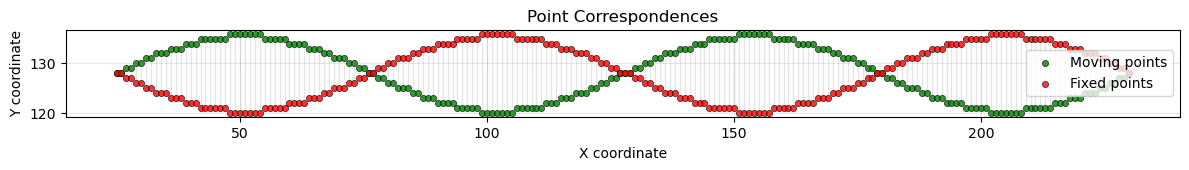

Analyzing 206 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 98 points (indices: [2, 3, 4, 5, 6]...)
  Mean displacement: Z=0.000, Y=-10.286, X=0.000
  Std displacement:  Z=0.000, Y=4.408, X=0.000
Cluster 1: 108 points (indices: [0, 1, 51, 52, 53]...)
  Mean displacement: Z=0.000, Y=9.333, X=0.000
  Std displacement:  Z=0.000, Y=5.150, X=0.000
ERROR: Error getting cluster indices. Ensure the points are in the correct format and the correct method is used (y_direction or x_direction). Using half of the points as down_indices and the other half as up_indices.


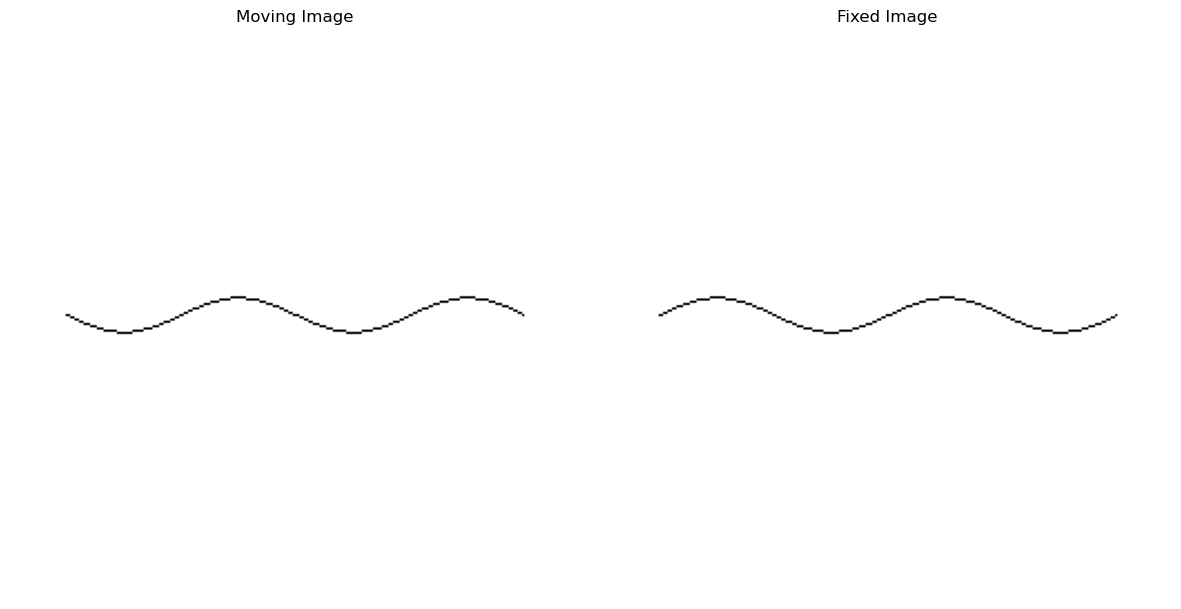

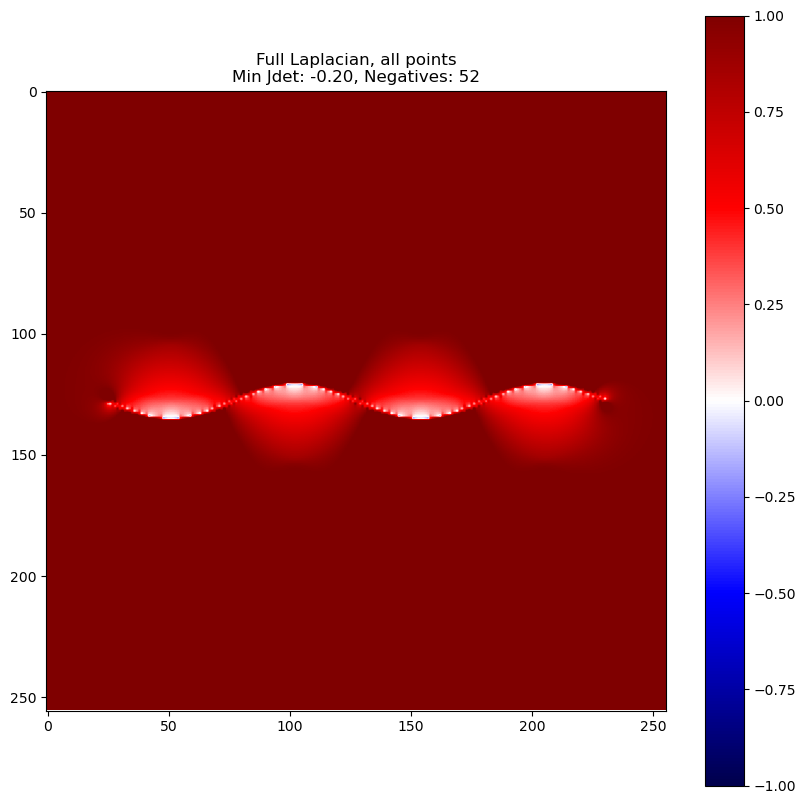

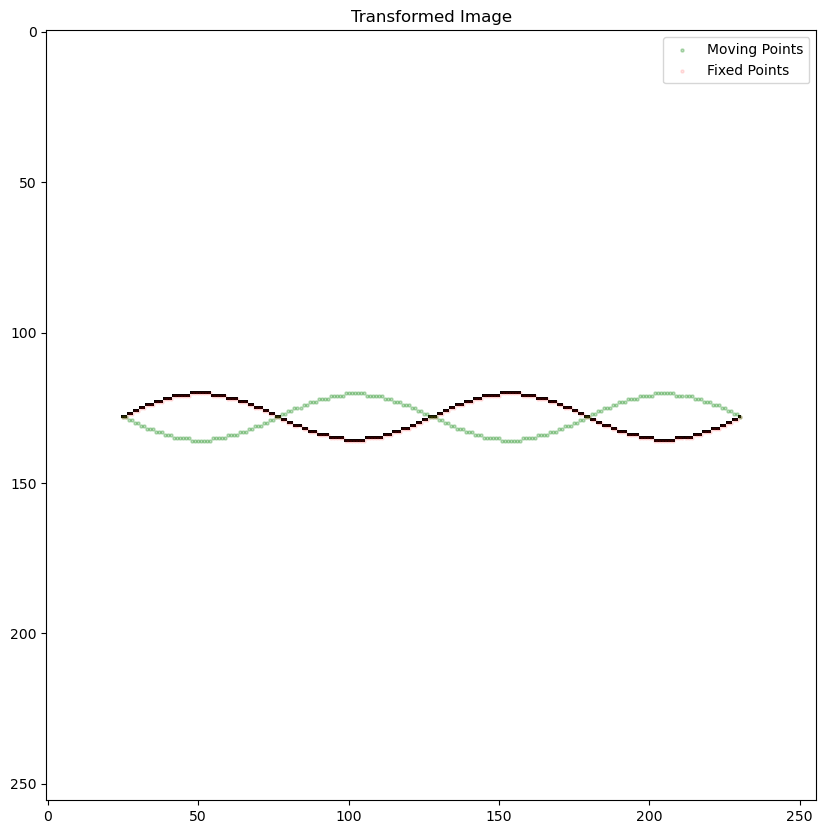

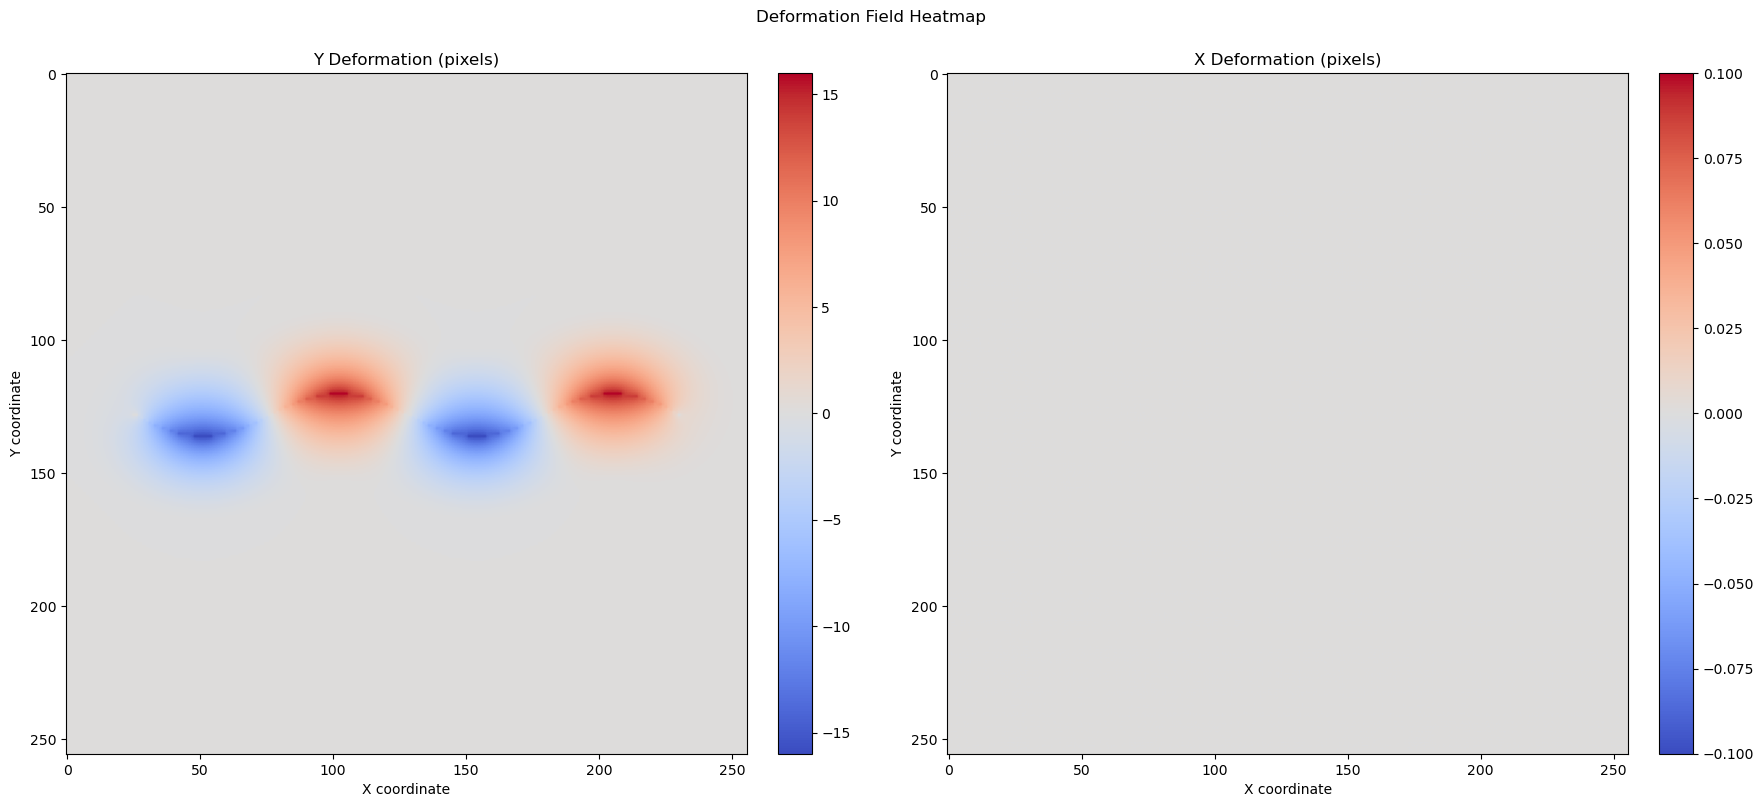

||Ax - b||: 1.51
Mean error at correspondences: 0.002190638643959975


In [24]:
#####################################################################################################
# SETUP 
#####################################################################################################

# Create a specific double helix for correspondence analysis
print("\n=== Creating Double Helix for Point Correspondence ===")
helix_wave1, helix_wave2, _ = data_utils.create_double_helix_waves(
    grid_size=min(resolution),
    num_cycles=2,
    amplitude_ratio=0.03,
    phase_offset=np.pi,  # 180 degrees for maximum separation
    padding_ratio=0.1,
    plot=False, horizontal=False,  # Set horizontal to False for vertical helix
)

# Swap with other data if provided
if m_data is not None:
    helix_wave1 = m_data
if f_data is not None:
    helix_wave2 = f_data
    
# Move helix_waves aways from each other
helix_wave1[:, 1] += -shift_distance
helix_wave2[:, 1] += shift_distance

#helix_wave1[:, 1] += 20 # y
#helix_wave1[:, 0] += 20 # x

# Decrease point density for better visualization
helix_wave1 = helix_wave1[::num_points_skip]  # Take every second point
helix_wave2 = helix_wave2[::num_points_skip]  # Take every second point

# Plot the correspondences between the two helical waves
data_utils.plot_point_correspondences(helix_wave1, helix_wave2,
                          labels=('Moving points', 'Fixed points'),
                          colors=('green', 'red'),
                          title='Point Correspondences',
                          show_indices=False,
                          line_alpha=0.2,  # More transparent lines to show the pattern better
                          point_size=20)

# Swap columns to match expected format (x, y)
helix_wave1 = helix_wave1[:, [1, 0]]  # Swap to (y, x) format
helix_wave2 = helix_wave2[:, [1, 0]]  # Swap to (y, x) format 

# Add 0s on the first axis to format for Data class
helix_wave1 = np.pad(helix_wave1, ((0, 0), (1, 0)), mode='constant', constant_values=0)
helix_wave2 = np.pad(helix_wave2, ((0, 0), (1, 0)), mode='constant', constant_values=0)

# Get the downwards and upwards clusters
try:
    cluster_indices, cluster_info = cluster.get_cluster_indices(helix_wave1, helix_wave2, method=cluster_method)
    down_indices = cluster_indices[0]
    up_indices = cluster_indices[1]
    raise Exception
except:
    print("ERROR: Error getting cluster indices. Ensure the points are in the correct format and the correct method is used (y_direction or x_direction). Using half of the points as down_indices and the other half as up_indices.")
    down_indices = [i for i in range(len(helix_wave1)//2)]
    up_indices = [i for i in range(len(helix_wave1)//2, len(helix_wave1))]

# Save to raw image
moving_img = data_utils.create_raw_image(helix_wave1, resolution, save_path="wave1.png")
fixed_img = data_utils.create_raw_image(helix_wave2, resolution, save_path="wave2.png")
data_utils.show_2_pngs(moving_img, fixed_img, title1="Moving Image", title2="Fixed Image")

#####################################################################################################
# Run Laplacian
#####################################################################################################

d = Data(helix_wave1, helix_wave2, resolution)
d_original = deepcopy(d)  # Save original data for later use

d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False, figsize=(10, 10),
       title=f"Full Laplacian, all points\nMin Jdet: {d.min():.2f}, Negatives: {d.count_negatives()}")
transformed_img = reg_utils.apply_transformation(d, moving_img, mpoints=d.mpoints, fpoints=d.fpoints, title="Transformed Image")
reg_utils.deformation_heatmap(d, title="Deformation Field Heatmap")

_, _, _, total_err = reg_utils.compute_error(d.resolution, helix_wave1, helix_wave2, d.deformation)
print(f"||Ax - b||: {total_err:.2f}")
errors = reg_utils.correspondence_error(d.deformation, helix_wave1, helix_wave2)
print("Mean error at correspondences:", np.mean(errors))
#rint("Max error at correspondences:", np.max(errors))

In [ ]:
#down_indices_copy = deepcopy(down_indices)
#up_indices_copy = deepcopy(up_indices)
#down_indices = down_indices_copy
#up_indices = up_indices_copy

## Run on individual clusters

In [13]:
RUN_EXPERIMENT = False
if RUN_EXPERIMENT:
        # Run Laplacian on down indices
        d = Data(helix_wave1[down_indices], helix_wave2[down_indices], resolution)
        d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False, binarize_negatives=False, figsize=(10, 10),
                title="Down Cluster\nMin Jdet: {:.2f}, Negatives: {}".format(d.min(), d.count_negatives()))
        _ = reg_utils.apply_transformation(d, moving_img, mpoints=d.mpoints, fpoints=d.fpoints, title="Transformed Moving Image (Down cluster)")
        _, _, _, total_err = reg_utils.compute_error(d.resolution, helix_wave1[down_indices], helix_wave2[down_indices], d.deformation)
        print(f"Down cluster error: {total_err:.2f}")

        # Run Laplacian on up indices
        d = Data(helix_wave1[up_indices], helix_wave2[up_indices], resolution)
        d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False, binarize_negatives=False, figsize=(10, 10),
                title=f"Up Cluster\nMin Jdet: {d.min():.2f}, Negatives: {d.count_negatives()}")
        _ = reg_utils.apply_transformation(d, moving_img, mpoints=d.mpoints, fpoints=d.fpoints, title="Transformed Moving Image (Up cluster)")
        _, _, _, total_err = reg_utils.compute_error(d.resolution, helix_wave1[up_indices], helix_wave2[up_indices], d.deformation)
        print(f"Up cluster error: {total_err:.2f}")

## Laplacian clustering

In [14]:
def compose_deformation_fields(def1, def2):
    """
    Compose two deformation fields: def1 followed by def2.
    def1, def2: shape (channels, batch, H, W)
    Returns: composed deformation field, same shape
    """
    _, batch, H, W = def1.shape
    composed = np.zeros_like(def1)
    # Create meshgrid of coordinates
    yy, xx = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    for b in range(batch):
        # Get where each pixel moves after def1, y1 and x1 are the new coordinates after applying def1
        y1 = yy + def1[1, b]
        x1 = xx + def1[2, b]
        # Sample def2 at the new locations (use nearest neighbor for simplicity)
        y1_clipped = np.clip(np.round(y1).astype(int), 0, H-1)
        x1_clipped = np.clip(np.round(x1).astype(int), 0, W-1)
        # Compose: total displacement = def1 + def2 at warped location
        # Fancy indexing: For each pixel (i, j), it fetches the value at [1, b, y1_clipped[i, j], x1_clipped[i, j]]
        composed[1, b] = def1[1, b] + def2[1, b, y1_clipped, x1_clipped]
        composed[2, b] = def1[2, b] + def2[2, b, y1_clipped, x1_clipped]
    return composed


def cluster_laplacian(moving_points, fixed_points, resolution, clusters, moving_img=None, verbose=True):
    """
    Apply manual cluster-wise deformation as in the 'Down first' block.
    Args:
        moving_points: np.ndarray, shape (N, 3)
        fixed_points: np.ndarray, shape (N, 3)
        resolution: tuple, image resolution
        clusters: list of lists/arrays, each contains indices for a cluster
        moving_img: optional, image for visualization
        verbose: bool, show plots and info
    Returns:
        d_combined: Data object with combined deformation
    """
    # Step 1: First cluster deformation
    cluster1_idx = clusters[0]
    cluster2_idx = clusters[1]
    d1 = Data(moving_points[cluster1_idx], fixed_points[cluster1_idx], resolution)
    if verbose:
        d1.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
                binarize_negatives=False, title=f"Cluster 1\nMin Jdet: {d1.min():.2f}, Negatives: {d1.count_negatives()}")
    if moving_img is not None:
        iter1 = reg_utils.apply_transformation(d1, moving_img, mpoints=moving_points, fpoints=fixed_points,
                                    title="Transformed Moving Image (Cluster 1)")
    else:
        iter1 = None

    # Step 2: Fix cluster 1 points, move cluster 2 points
    new_mpoints = moving_points.copy()
    new_fpoints = fixed_points.copy()
    new_mpoints[cluster1_idx] = new_fpoints[cluster1_idx]  # Fix moving points to fixed points

    for idx in cluster2_idx:
        curr_mcoord = moving_points[idx]
        curr_fcoord = fixed_points[idx]
        
        #curr_mcoord = np.round(curr_mcoord).astype(int)
        #curr_fcoord = np.round(curr_fcoord).astype(int)
        
        new_mdisplacement = d1.deformation[:, 0, np.round(curr_mcoord[1]).astype(int), np.round(curr_mcoord[2]).astype(int)]
        new_fdisplacement = d1.deformation[:, 0, np.round(curr_fcoord[1]).astype(int), np.round(curr_fcoord[2]).astype(int)]
        # Optionally use new_fdisplacement, but original code uses new_mdisplacement for both
        new_mcoord = curr_mcoord + new_mdisplacement
        new_mcoord = np.round(new_mcoord).astype(int)
        #new_fcoord = curr_fcoord + new_mdisplacement
        new_fcoord = curr_fcoord + new_fdisplacement  # Use same displacement for fixed points
        new_fcoord = np.round(new_fcoord).astype(int)
        new_mpoints[idx] = new_mcoord
        new_fpoints[idx] = new_fcoord

    # Step 4: New Data object with updated points
    d2 = Data(new_mpoints, new_fpoints, resolution)
    if verbose:
        d2.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
                binarize_negatives=False, title=f"Cluster 2\nMin Jdet: {d2.min():.2f}, Negatives: {d2.count_negatives()}")
    if moving_img is not None and iter1 is not None:
        iter2_reg = reg_utils.apply_transformation(d2, iter1, mpoints=moving_points, fpoints=fixed_points,
                                                   title="Transformed Moving Image (Cluster 2)")

    # Step 5: Combine deformation fields
    d_combined = Data(moving_points, fixed_points, resolution)
    d_combined.deformation = compose_deformation_fields(d1.deformation, d2.deformation)
    d_combined.jdet_field = jacobian.sitk_jacobian_determinant(d_combined.deformation)[0]
    if verbose:
        d_combined.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
                        title=f"Combined Deformation\nMin Jdet: {d_combined.min():.2f}, Negatives: {d_combined.count_negatives()}")
    if moving_img is not None:
        composed_reg = reg_utils.apply_transformation(d_combined, moving_img, mpoints=moving_points, fpoints=fixed_points,
                            title="Transformed Moving Image (Composed Deformation)")
        print("L2 difference between iteration 2 and composed deformation:", np.linalg.norm(iter2_reg - composed_reg))

    return d_combined



In [15]:
print(up_indices)
print(down_indices)

[205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,

In [25]:
# Get coordinates where 
d_original.get_negative_coordinates()

Negative Jacobian determinants:
(121, 99)
(121, 100)
(121, 101)
(121, 102)
(121, 103)
(121, 104)
(121, 105)
(121, 202)
(121, 203)
(121, 204)
(121, 205)
(121, 206)
(121, 207)
(121, 208)
(122, 94)
(122, 110)
(122, 111)
(122, 197)
(122, 213)
(122, 214)
(123, 90)
(123, 114)
(123, 193)
(123, 217)
(124, 87)
(124, 190)
(132, 66)
(132, 169)
(133, 39)
(133, 63)
(133, 142)
(133, 166)
(134, 42)
(134, 43)
(134, 59)
(134, 145)
(134, 146)
(134, 162)
(135, 48)
(135, 49)
(135, 50)
(135, 51)
(135, 52)
(135, 53)
(135, 54)
(135, 151)
(135, 152)
(135, 153)
(135, 154)
(135, 155)
(135, 156)
(135, 157)


array([[121,  99],
       [121, 100],
       [121, 101],
       [121, 102],
       [121, 103],
       [121, 104],
       [121, 105],
       [121, 202],
       [121, 203],
       [121, 204],
       [121, 205],
       [121, 206],
       [121, 207],
       [121, 208],
       [122,  94],
       [122, 110],
       [122, 111],
       [122, 197],
       [122, 213],
       [122, 214],
       [123,  90],
       [123, 114],
       [123, 193],
       [123, 217],
       [124,  87],
       [124, 190],
       [132,  66],
       [132, 169],
       [133,  39],
       [133,  63],
       [133, 142],
       [133, 166],
       [134,  42],
       [134,  43],
       [134,  59],
       [134, 145],
       [134, 146],
       [134, 162],
       [135,  48],
       [135,  49],
       [135,  50],
       [135,  51],
       [135,  52],
       [135,  53],
       [135,  54],
       [135, 151],
       [135, 152],
       [135, 153],
       [135, 154],
       [135, 155],
       [135, 156],
       [135, 157]], dtype=int64

In [37]:
pt = (121, 206)
current_jdet = d_original.jdet_field[pt[0], pt[1]]
current = d_original.deformation[:, 0, pt[0], pt[1]]
down = d_original.deformation[:, 0, pt[0]-1, pt[1]]
up = d_original.deformation[:, 0, pt[0]+1, pt[1]]
left = d_original.deformation[:, 0, pt[0], pt[1]-1]
right = d_original.deformation[:, 0, pt[0], pt[1]+1]
print("Jdet:", current_jdet)
print("Current:", current)
print("Down:", down)
print("Up:", up)
print("Left:", left)
print("Right:", right)

((down - up) / 2) - (right - left) / 2

Jdet: -0.0561946546394827
Current: [ 0.         14.90782769  0.        ]
Down: [ 0.         15.99641848  0.        ]
Up: [ 0.         13.88402917  0.        ]
Left: [ 0.         14.92907265  0.        ]
Right: [ 0.         14.82573289  0.        ]


array([0.        , 1.10786454, 0.        ])

In [40]:
def jacobian_determinant(field, pt):
    """
    Compute the Jacobian determinant at a given point in a 2D vector field.
    field: np.ndarray, shape (channels, batch, H, W) or (channels, H, W)
    pt: tuple (y, x)
    Returns: float, Jacobian determinant at pt
    """
    # If field has batch dimension, use batch 0
    if field.ndim == 4:
        field = field[:, 0]
    y, x = pt
    H, W = field.shape[-2], field.shape[-1]

    # Compute central differences for each channel
    dy1, dx1 = central_difference(field[1], pt)  # y-displacement
    dy2, dx2 = central_difference(field[2], pt)  # x-displacement

    # Jacobian matrix:
    # [1 + dy1, dx1]
    # [dy2, 1 + dx2]
    J = np.array([[1 + dy1, dx1],
                  [dy2, 1 + dx2]])
    return np.linalg.det(J)

J = jacobian_determinant(d_original.deformation, pt)
J

-0.05619465463948269

In [38]:
# Central differences for a point pt = (y, x) in a 2D field
def central_difference(field, pt):
    """
    Compute central differences at a given point in a 2D field.
    field: np.ndarray, shape (..., H, W)
    pt: tuple (y, x)
    Returns: dy, dx (central differences along y and x)
    """
    y, x = pt
    # Handle boundaries by using forward/backward difference if needed
    H, W = field.shape[-2], field.shape[-1]
    if y == 0:
        dy = field[..., y+1, x] - field[..., y, x]
    elif y == H-1:
        dy = field[..., y, x] - field[..., y-1, x]
    else:
        dy = (field[..., y+1, x] - field[..., y-1, x]) / 2
    if x == 0:
        dx = field[..., y, x+1] - field[..., y, x]
    elif x == W-1:
        dx = field[..., y, x] - field[..., y, x-1]
    else:
        dx = (field[..., y, x+1] - field[..., y, x-1]) / 2
    return dy, dx

# Example usage:
pt = (121, 206)
dy, dx = central_difference(d_original.deformation, pt)
print("Central difference dy:", dy)
print("Central difference dx:", dx)

Central difference dy: [[ 0.        ]
 [-1.05619465]
 [ 0.        ]]
Central difference dx: [[ 0.        ]
 [-0.05166988]
 [ 0.        ]]


### Down first

Down indices then up indices


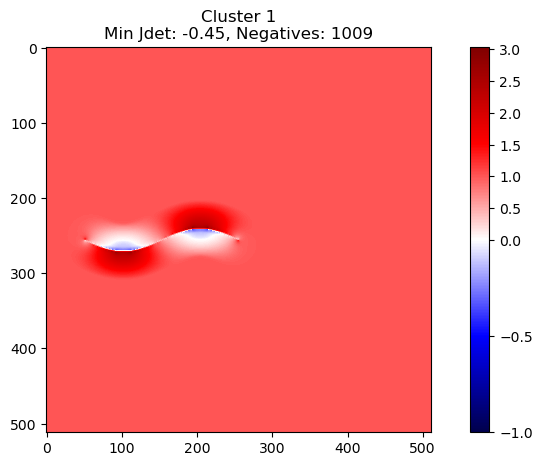

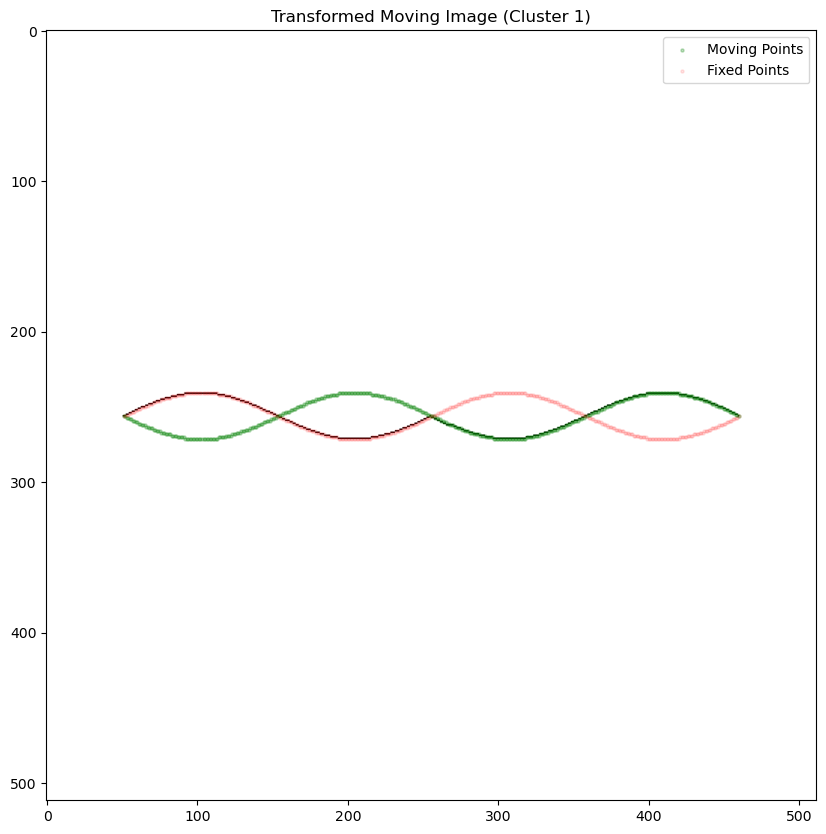

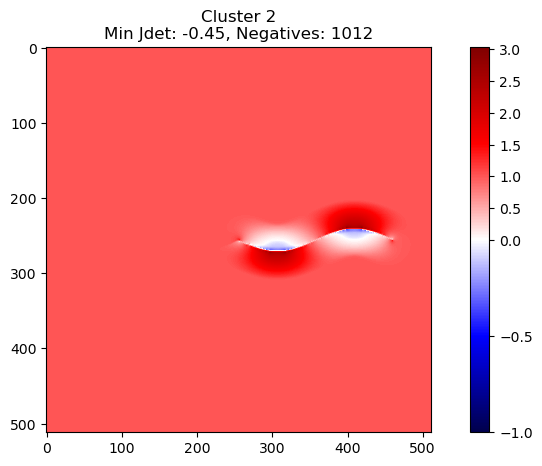

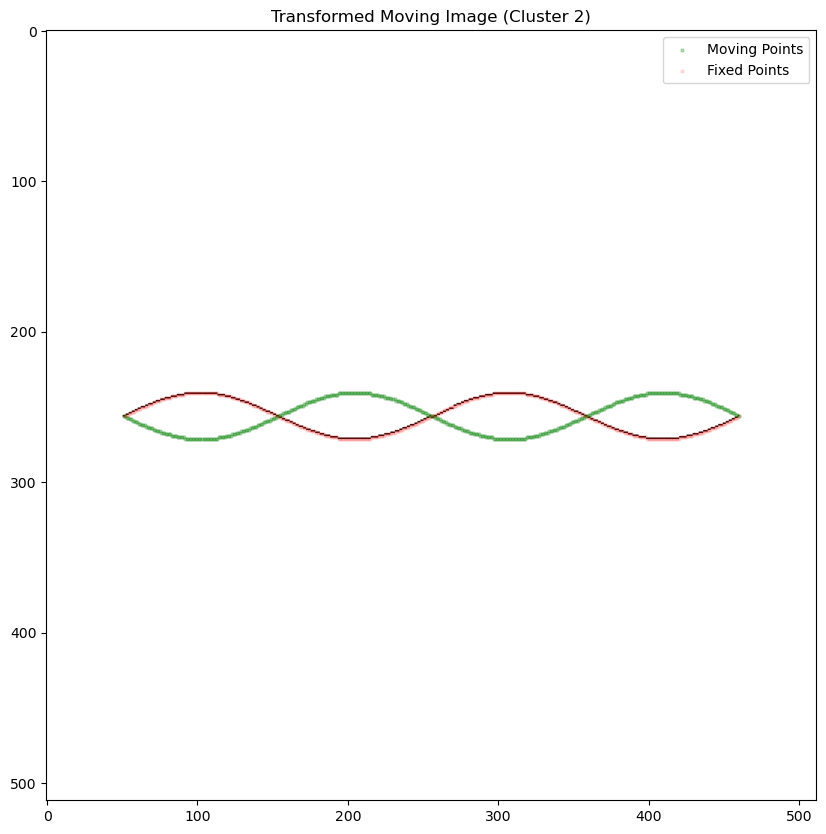

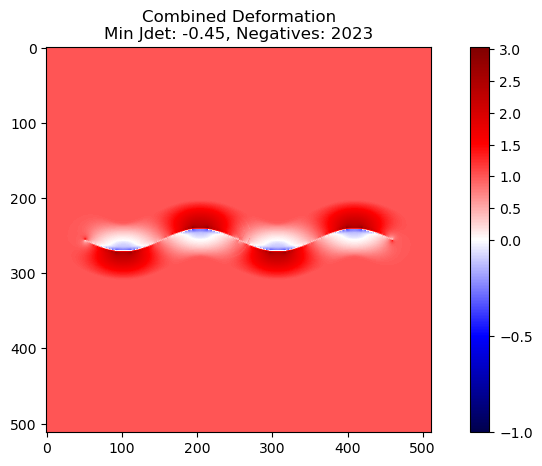

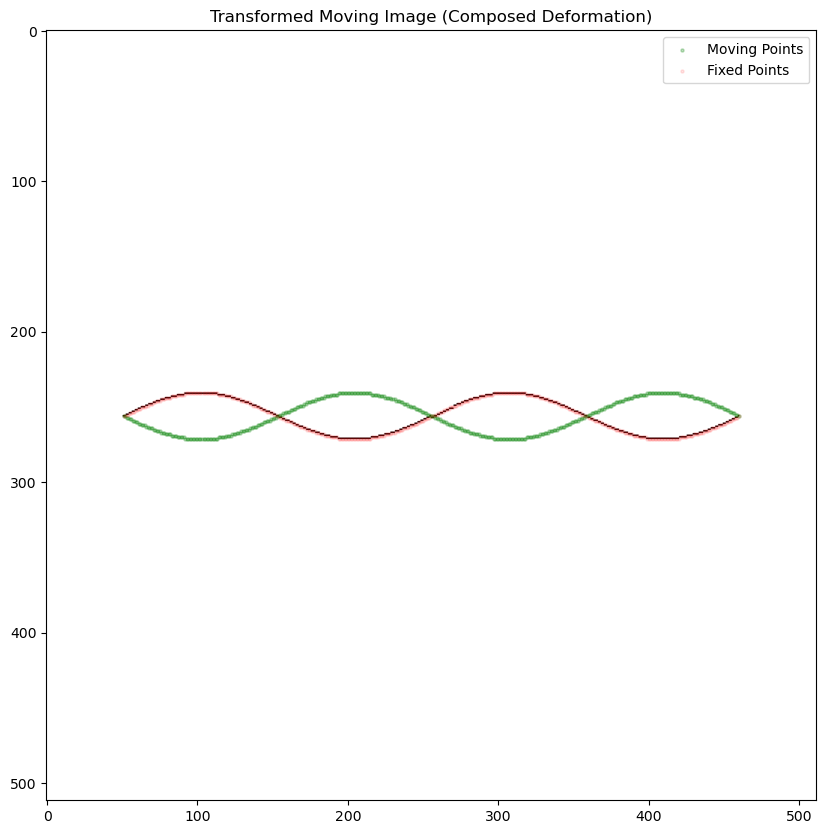

L2 difference between iteration 2 and composed deformation: 0.0
||Ax̂ - b|| for cluster-based deformation: 8.56
L2 error between original deformation and cluster-based deformation: 12.82
Mean error at correspondences: 0.04182812605584625


In [16]:
print("Down indices then up indices")
d_result = cluster_laplacian(helix_wave1, helix_wave2, resolution, [down_indices, up_indices], moving_img)
_, _, _, total_err = reg_utils.compute_error(d_result.resolution, helix_wave1, helix_wave2, d_result.deformation)
print(f"||Ax̂ - b|| for cluster-based deformation: {total_err:.2f}")
print(f"L2 error between original deformation and cluster-based deformation: {np.linalg.norm(d_original.deformation - d_result.deformation):.2f}")
errors = reg_utils.correspondence_error(d_result.deformation, helix_wave1, helix_wave2)
print("Mean error at correspondences:", np.mean(errors))
#print("Max error at correspondences:", np.max(errors))

### Up first

Up indices then down indices


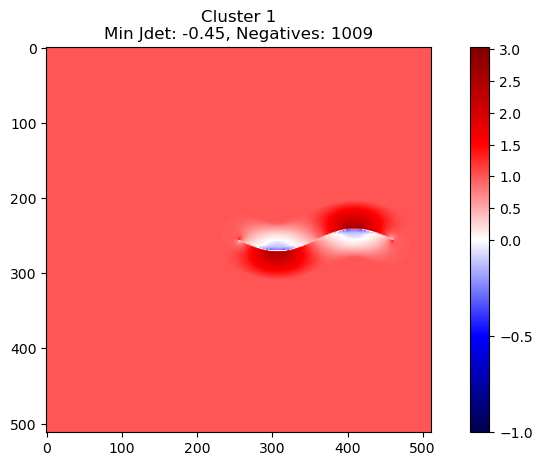

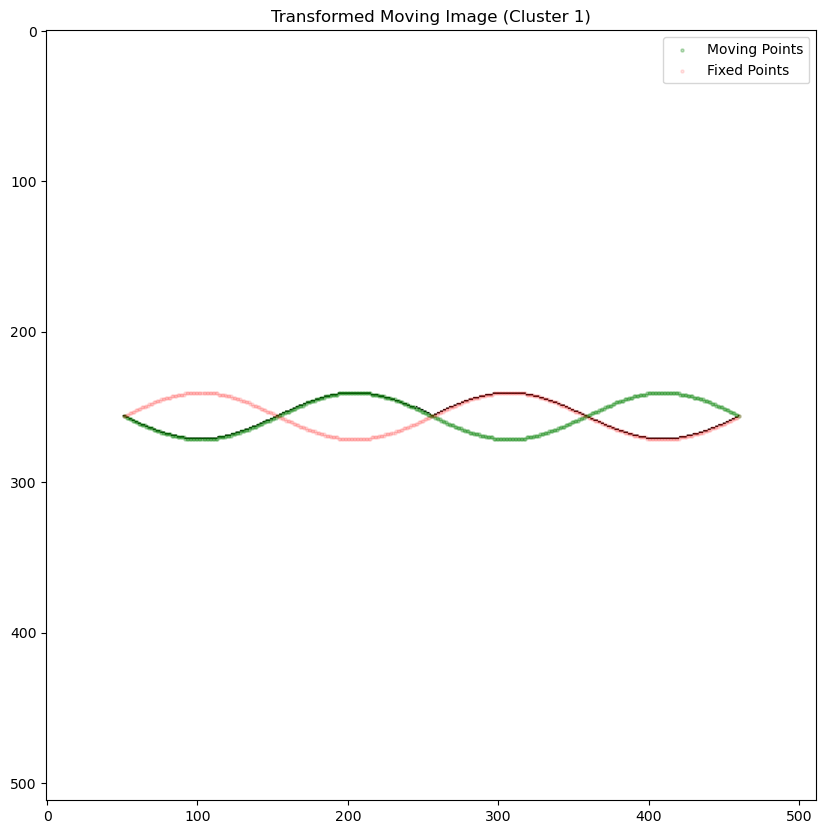

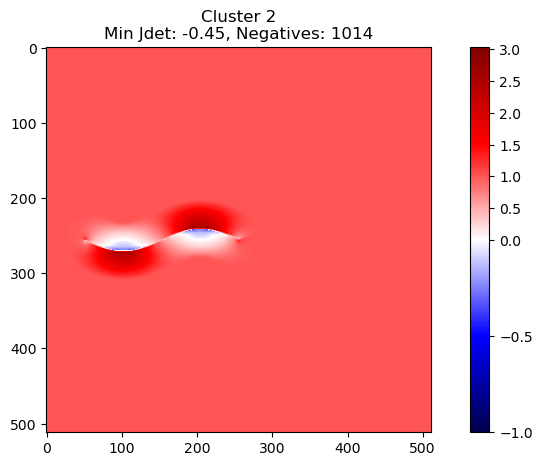

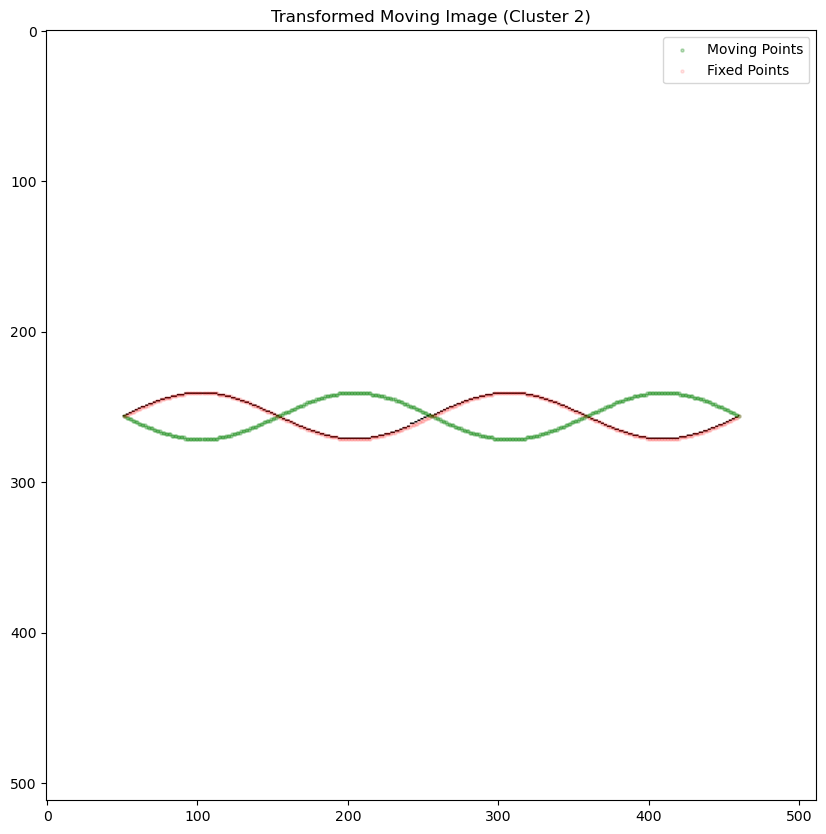

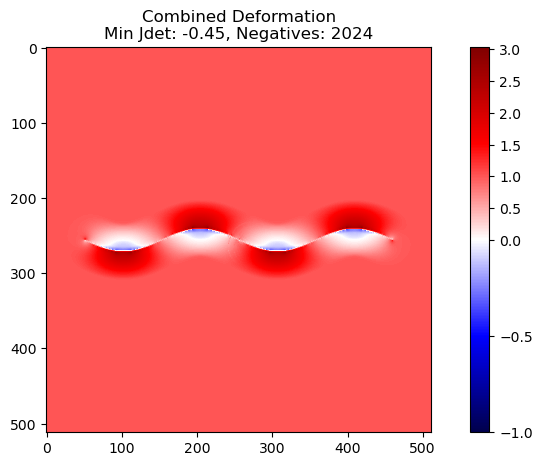

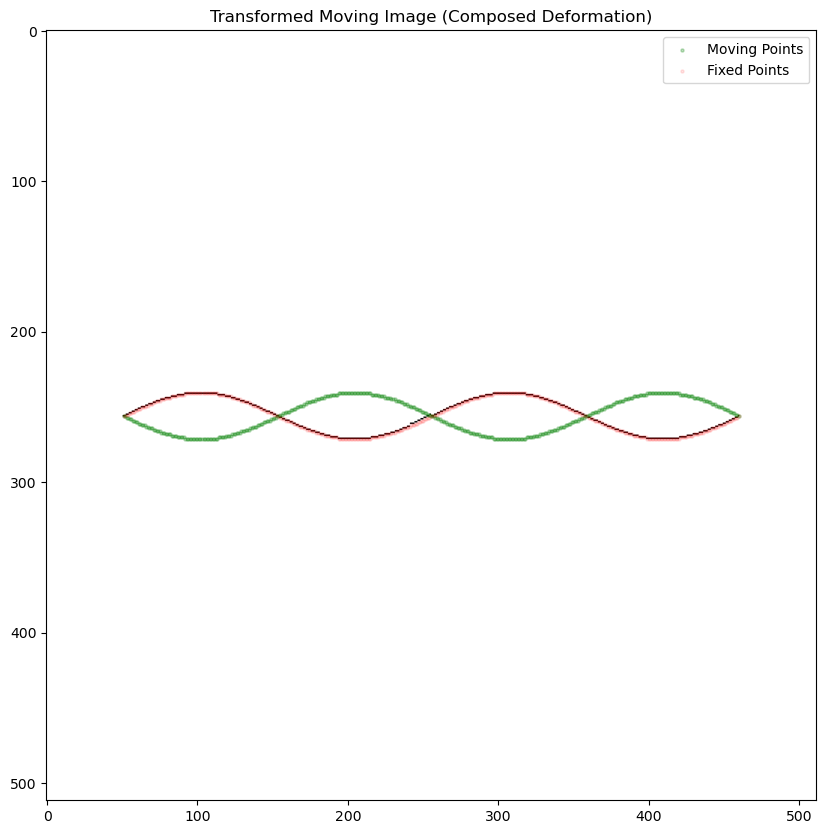

L2 difference between iteration 2 and composed deformation: 0.0
||Ax̂ - b|| for cluster-based deformation: 8.47
L2 error between original deformation and cluster-based deformation: 11.46
Mean error at correspondences: 0.0361385074702535


In [17]:
print("Up indices then down indices")
d_result = cluster_laplacian(helix_wave1, helix_wave2, resolution, [up_indices, down_indices], moving_img)
_, _, _, total_err = reg_utils.compute_error(d_result.resolution, helix_wave1, helix_wave2, d_result.deformation)
print(f"||Ax̂ - b|| for cluster-based deformation: {total_err:.2f}")
print(f"L2 error between original deformation and cluster-based deformation: {np.linalg.norm(d_original.deformation - d_result.deformation):.2f}")
errors = reg_utils.correspondence_error(d_result.deformation, helix_wave1, helix_wave2)
print("Mean error at correspondences:", np.mean(errors))
#print("Max error at correspondences:", np.max(errors))

# Run ANTs

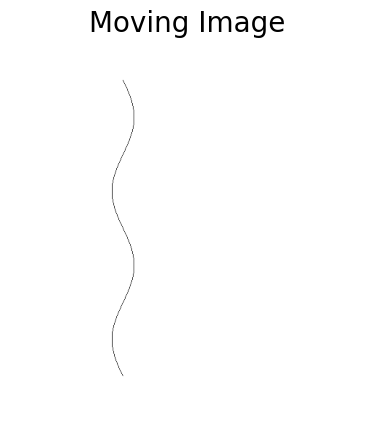

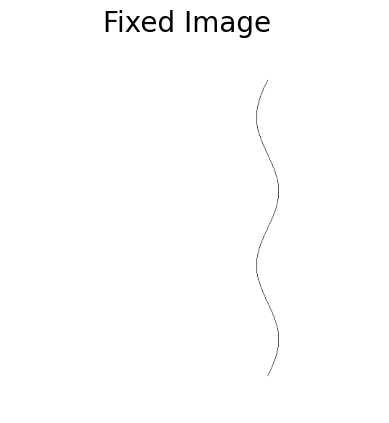

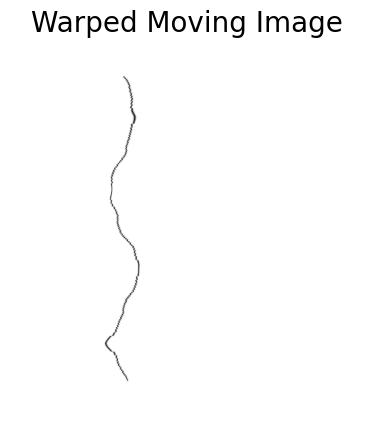

In [300]:
import ants

# Convert numpy arrays to ANTs images
moving_ants = ants.from_numpy(moving_img)
fixed_ants = ants.from_numpy(fixed_img)

# Perform registration (SyN is typical for nonrigid)
reg = ants.registration(
    fixed=fixed_ants,
    moving=moving_ants,
    type_of_transform='SyN'
)

# Get the warped image
warped_moving = reg['warpedmovout']

# Show result
ants.plot(moving_ants, title='Moving Image')
ants.plot(fixed_ants, title='Fixed Image')
ants.plot(warped_moving, title='Warped Moving Image')

# End